In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import random

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from src.models.unet import UNet
import src.config as global_config
from src.data_access.data_generation import DataGenerator
from src.data_access.folds_generation import FoldsGenerator
import src.data_access.config as data_access_config
from src.data_access.utils import prepare_class_weighting, \
    convert_class_weighting_to_vector
from src.evaluation.losses.dice import dice_loss, bce_dice_loss

In [8]:
u_net = UNet(num_classes=len(global_config.CLASS_MAPPINGS) + 1)

In [9]:
input_size = global_config.MODEL_INPUT_SIZE.to_compact_form() + (3, )
print(input_size)
model = u_net.build_model(input_shape=input_size)

(128, 128, 3)
Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sub_stack_1_1 (Conv2D)          (None, 128, 128, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
sub_stack_1_2 (Conv2D)          (None, 128, 128, 64) 36928       sub_stack_1_1[0][0]              
__________________________________________________________________________________________________
sub_stack_1_3 (Conv2D)          (None, 128, 128, 64) 36928       sub_stack_1_2[0][0]              
__________________________________________________________________________________________________
sub_stack_

In [11]:
folds_genarator = FoldsGenerator(
    dataset_path=global_config.DATASET_PATH,
    generator_specs=data_access_config.FOLDS_GENERATOR_SPECS
)

In [12]:
dataset_split = next(folds_genarator.generate_folds())

In [13]:
dataset_split.test_set.classes_balance

{'duck': 0.1450381679389313,
 'clamp': 0.16793893129770993,
 'adapter': 0.22137404580152673,
 'drill': 0.21374045801526717,
 'box': 0.0916030534351145,
 'bottle': 0.16030534351145037}

In [14]:
dataset_split.training_set.classes_balance

{'duck': 0.14534883720930233,
 'clamp': 0.16666666666666666,
 'adapter': 0.22286821705426357,
 'drill': 0.21705426356589147,
 'box': 0.09302325581395349,
 'bottle': 0.15503875968992248}

In [15]:
training_set = dataset_split.training_set
test_set = dataset_split.test_set

In [16]:
class_weights = prepare_class_weighting(
    class_balance=training_set.classes_balance,
    class_mapping=global_config.CLASS_MAPPINGS
)

In [17]:
class_weights_vector = convert_class_weighting_to_vector(
    class_weighting=class_weights
)

In [18]:
class_weights

{6: 0.1723363816134394,
 4: 0.15029336928403944,
 1: 0.11239331925278236,
 5: 0.11540385320291446,
 3: 0.2692754920614553,
 2: 0.16156536470990535,
 0: 0.018732219875463727}

In [19]:
class_weights_vector

array([0.01873222, 0.11239332, 0.16156536, 0.2692755 , 0.15029337,
       0.11540385, 0.17233638], dtype=float32)

In [20]:
np.sum(class_weights_vector)

1.0

In [21]:
training_generator = DataGenerator(
    examples=training_set.examples,
    transformation_chain=data_access_config.TRAINING_TRANSFORMATION_CHAIN,
    batch_size=16
)
test_generator = DataGenerator(
    examples=test_set.examples,
    transformation_chain=data_access_config.VALIDATION_TRANSFORMATION_CHAIN,
    batch_size=16
)

In [22]:
test_generator[0][1].shape

(16, 128, 128, 7)

In [23]:
model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics=[dice_loss]
)

In [24]:
model.fit_generator(
    training_generator, 
    epochs=32, 
    verbose=1,
    callbacks=None,
    validation_data=test_generator, 
    max_queue_size=10,
    workers=24,
    use_multiprocessing=True
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/32
32/32 [==============================] - 12s 373ms/step - loss: 14.3183 - dice_loss: 0.5210 - val_loss: 75.3012 - val_dice_loss: 0.0296
Epoch 2/32
32/32 [==============================] - 8s 246ms/step - loss: 8.1612 - dice_loss: 0.7123 - val_loss: 53.6421 - val_dice_loss: 0.3490
Epoch 3/32
32/32 [==============================] - 9s 269ms/step - loss: 5.5176 - dice_loss: 0.8030 - val_loss: 31.5849 - val_dice_loss: 0.5327
Epoch 4/32
32/32 [==============================] - 9s 272ms/step - loss: 3.9242 - dice_loss: 0.8633 - val_loss: 17.9337 - val_dice_loss: 0.6769
Epoch 5/32
32/32 [==============================] - 9s 269ms/step - loss: 3.6721 - dice_loss: 0.8749 - val_loss: 4.2601 - val_dice_loss: 0.8764
Epoch 6/32
32/32 [==============================] - 8s 249ms/step - loss: 3.2435 - dice_loss: 0.8908 - val_loss: 3.1652 - val_dice_loss: 0.9069
Epoch 7/32
32/32 [==============================] - 8s 250ms/step - loss: 3.1937 -

In [25]:
model.save(os.path.join(global_config.MODELS_PATH, "u_net.h5"))

In [26]:
test_batch = test_generator[1]

In [45]:
test_sample = test_batch[0][7]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


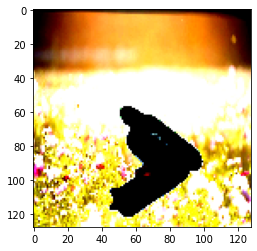

In [46]:
plt.imshow(test_sample)

In [47]:
prediction = model.predict(np.expand_dims(test_sample, axis=0))

In [48]:
prediction = np.argmax(prediction, axis=-1)

In [49]:
prediction = np.squeeze(prediction, axis=0)

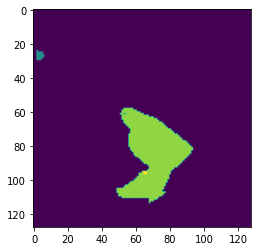

In [50]:
plt.imshow(prediction)

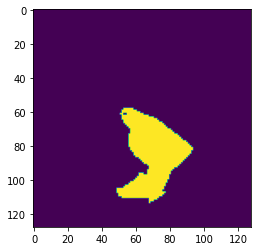

In [53]:
plt.imshow(prediction == 5)